## Import data

In [1]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 1058508 out of 2097150 valid rows.
Building 2 has 137790 out of 520938 valid rows.
Building 3 has 619925 out of 1942515 valid rows.


## Data preparation

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels
- Cumulative metrics probably won't be available when trying to predict future values
- `Louver_status` values are missing in building 3

In [2]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]
exclude_df3 = exclude + ["Louver_status"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude_df3)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [3]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

#import seaborn as sns
#sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

Remove rows with `NA` values for columns that do not have many `NA` values.

In [4]:
print(len(df1))
df1.isna().sum()

1058508


Ambient_temp              11022
Ambient_temp_diff         21648
DOW                           0
Damper_status            955182
Datetime_diff_mins            0
Day                           0
Fan_status                    0
Month                         0
Season                        0
Zone_name                     0
Zone_temp                     0
Zone_temp_diff                0
Day_of_Year                   0
Minutes_past_midnight         0
dtype: int64

In [5]:
print(len(df2))
df2.isna().sum()

137790


Ambient_temp               4790
Ambient_temp_diff          4795
DOW                           0
Datetime_diff_mins            0
Day                           0
Dew_temp                      0
Dew_temp_diff                 0
Fan_status                    0
Month                         0
Season                        0
Slab_temp                     0
Slab_temp_diff                0
Zone_c02                  14195
Zone_name                     0
Zone_temp                110232
Zone_temp_diff           110232
Day_of_Year                   0
Minutes_past_midnight         0
dtype: int64

In [6]:
print(len(df3))
df3.isna().sum()

619925


Ambient_temp                0
Ambient_temp_diff          45
DOW                         0
Damper_status               0
Datetime_diff_mins         15
Day                         0
Dew_temp                 4389
Dew_temp_diff            4453
Fan_status                  0
Month                       0
Season                      0
Slab_temp                 812
Slab_temp_diff            868
Zone_c02                   22
Zone_name                   0
Zone_temp                2670
Zone_temp_diff           2730
Day_of_Year                 0
Minutes_past_midnight       0
dtype: int64

Encode `Zone_name` as numeric variables.

In [7]:
categorical_columns = ["Zone_name", "DOW"]
df1 = pd.get_dummies(df1, columns=categorical_columns)
dfs[0] = df1
df2 = pd.get_dummies(df2, columns=categorical_columns)
dfs[1] = df2
df3 = pd.get_dummies(df3, columns=categorical_columns)
dfs[2] = df3

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [8]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [9]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        train.drop(drop, inplace=True)

In [10]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Evaluating Model Performance

In [11]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.pipeline import Pipeline

def calculate_metrics(model: Pipeline, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "f1": f1_score(y, y_predict, pos_label="On"),
        "ROC AUC": roc_auc_score(y, y_proba),
        "PR AUC": average_precision_score(y, y_proba, pos_label="On"),
        "Matthews": matthews_corrcoef(y, y_predict)
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(random_state=42)
model_name = "Decision Tree"

### Building 1

[Text(0.5, 0.8333333333333334, 'Zone_temp <= 15.55\ngini = 0.388\nsamples = 846806\nvalue = [223280.0, 623526.0]'),
 Text(0.25, 0.5, 'Zone_temp <= 2.75\ngini = 0.027\nsamples = 110494\nvalue = [108984, 1510]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'Day_of_Year <= 7.5\ngini = 0.262\nsamples = 736312\nvalue = [114296, 622016]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

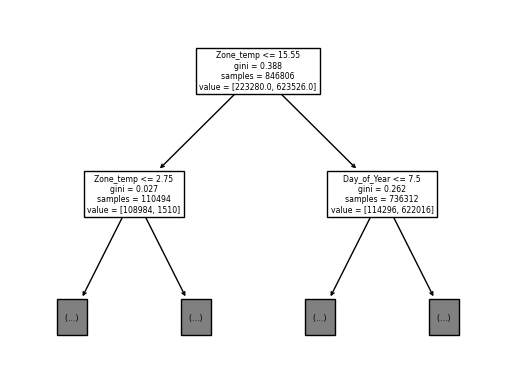

In [13]:
tree.fit(x_train1, y_train1)
plot_tree(tree, max_depth=1, feature_names=features1)

In [14]:
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9997    0.9994    0.9995     27625
          On     0.9998    0.9999    0.9998     78226

    accuracy                         0.9998    105851
   macro avg     0.9997    0.9997    0.9997    105851
weighted avg     0.9998    0.9998    0.9998    105851



### Building 2

[Text(0.5, 0.8333333333333334, 'Slab_temp_diff <= 0.005\ngini = 0.375\nsamples = 57464\nvalue = [43098, 14366]'),
 Text(0.25, 0.5, 'Zone_c02 <= 491.425\ngini = 0.275\nsamples = 36168\nvalue = [30227, 5941]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'Zone_name_Ac-2-2 <= 0.5\ngini = 0.478\nsamples = 21296\nvalue = [12871, 8425]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

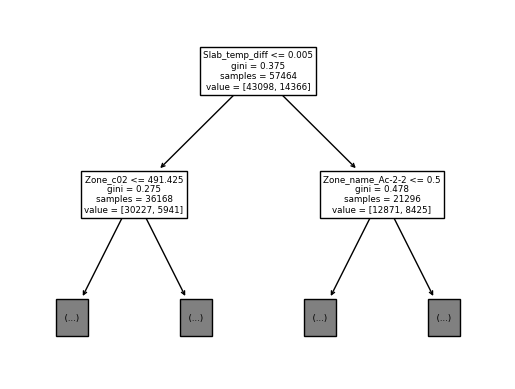

In [15]:
tree.fit(x_train2, y_train2)
plot_tree(tree, max_depth=1, feature_names=features2)

In [16]:
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9819    0.9615    0.9716     11990
          On     0.7734    0.8815    0.8239      1789

    accuracy                         0.9511     13779
   macro avg     0.8777    0.9215    0.8978     13779
weighted avg     0.9549    0.9511    0.9524     13779



### Building 3

[Text(0.625, 0.875, 'Zone_name_L1-03 <= 0.5\ngini = 0.375\nsamples = 486824\nvalue = [365118, 121706]'),
 Text(0.5, 0.625, 'Damper_status <= 34.167\ngini = 0.315\nsamples = 453925\nvalue = [365118, 88807]'),
 Text(0.25, 0.375, 'Day_of_Year <= 356.5\ngini = 0.141\nsamples = 309756\nvalue = [286084, 23672]'),
 Text(0.125, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.375, 'Damper_status <= 59.8\ngini = 0.495\nsamples = 144169\nvalue = [79034, 65135]'),
 Text(0.625, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 32899\nvalue = [0, 32899]')]

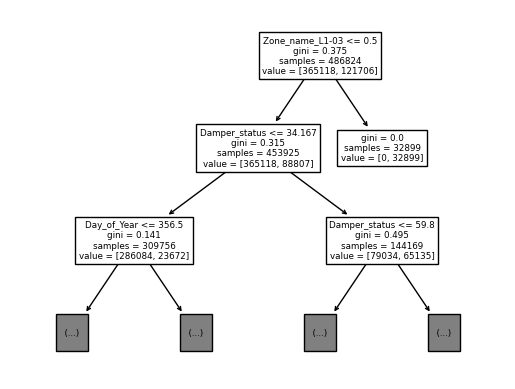

In [17]:
tree.fit(x_train3, y_train3)
plot_tree(tree, max_depth=2, feature_names=features3)

In [18]:
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9917    0.9919    0.9918     46578
          On     0.9756    0.9748    0.9752     15414

    accuracy                         0.9877     61992
   macro avg     0.9836    0.9833    0.9835     61992
weighted avg     0.9877    0.9877    0.9877     61992



## Random Forest
### Building 1

<Axes: >

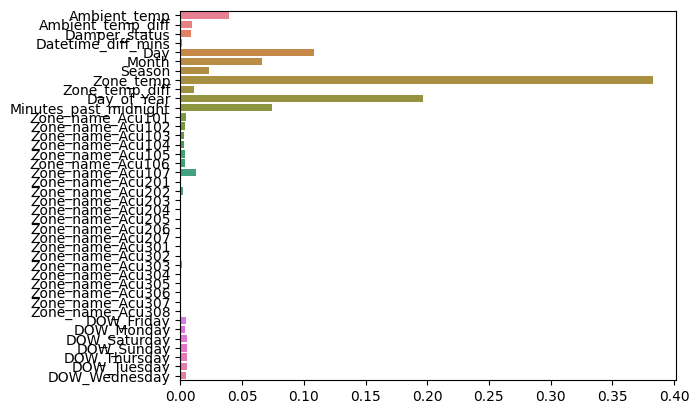

In [19]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train1, y_train1)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features1).T, orient="h")

In [20]:
model_name = "Random Forest"
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9994    0.9991    0.9992     27625
          On     0.9997    0.9998    0.9997     78226

    accuracy                         0.9996    105851
   macro avg     0.9995    0.9994    0.9995    105851
weighted avg     0.9996    0.9996    0.9996    105851



### Building 2

<Axes: >

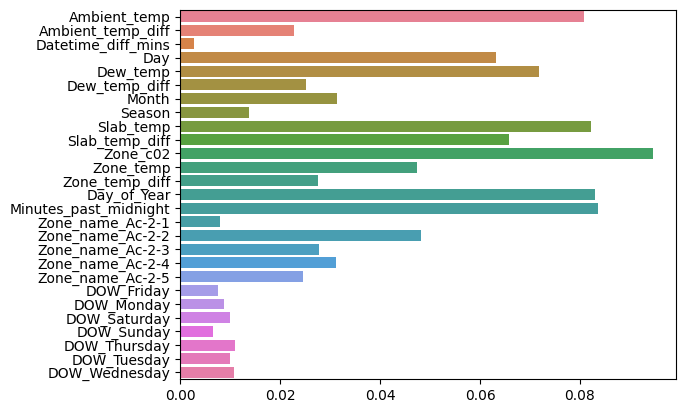

In [21]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train2, y_train2)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features2).T, orient="h")

In [22]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9869    0.9818    0.9844     11990
          On     0.8822    0.9128    0.8973      1789

    accuracy                         0.9729     13779
   macro avg     0.9346    0.9473    0.9408     13779
weighted avg     0.9733    0.9729    0.9731     13779



### Building 3

<Axes: >

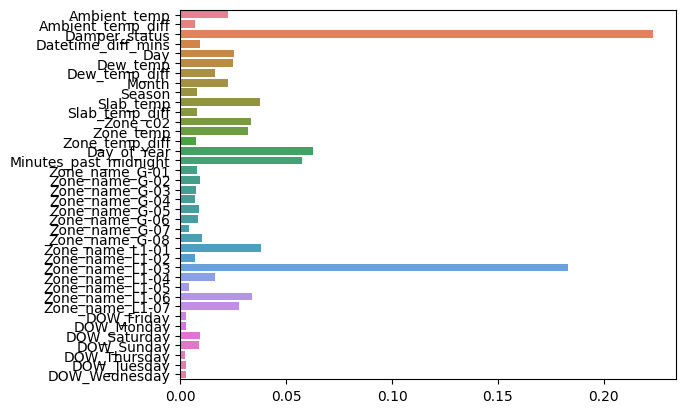

In [23]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train3, y_train3)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features3).T, orient="h")

In [24]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9925    0.9965    0.9945     46578
          On     0.9894    0.9774    0.9833     15414

    accuracy                         0.9918     61992
   macro avg     0.9909    0.9869    0.9889     61992
weighted avg     0.9917    0.9918    0.9917     61992



## 

## Model Performance
### Building 1

In [25]:
pd.DataFrame(model_metrics["Building 1"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.999764,0.999840,0.999653,0.999765,0.999388
Random Forest,0.999603,0.999732,0.999999,1.000000,0.998971


### Building 2

In [26]:
pd.DataFrame(model_metrics["Building 2"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.951085,0.823929,0.921483,0.697152,0.797962
Random Forest,0.972857,0.897253,0.991812,0.959032,0.881791


### Building 3

In [27]:
pd.DataFrame(model_metrics["Building 3"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.987660,0.975174,0.983345,0.957240,0.966964
Random Forest,0.991757,0.983323,0.999558,0.998756,0.977881


## Model Tuning

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

### Decision Tree

0it [00:00, ?it/s]


<Axes: xlabel='nodes'>

DecisionTreeClassifier(ccp_alpha=2.0882639565641096e-05, random_state=42)

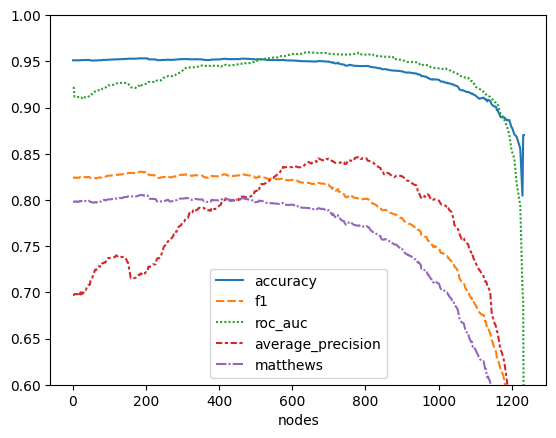

In [28]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, average_precision_score
from joblib import Parallel, delayed
from tqdm import tqdm

# TODO: create base class OptimisedModel
class OptimisedDecisionTree:
    def __init__(self, save_path: str | Path = None, random_state=42):
        self._results = None
        self._random_state = random_state

        self._output_folder = Path("output/decision_tree")
        if save_path is not None:
            self._output_folder = self._output_folder / save_path
        self._index_file = self._output_folder / "index.pkl"
        # create output folder if it does not exist
        self._output_folder.mkdir(parents=True, exist_ok=True)

        # unique to decision tree
        self._base = DecisionTreeClassifier
        self._model = DecisionTreeClassifier(random_state=random_state)
        self._extra_columns = {
            "depth": lambda clf: clf.tree_.max_depth,
            "nodes": lambda clf: clf.tree_.node_count,
        }

    @property
    def model(self):
        return self._model
    
    @property
    def results(self):
        if self._results is None:
            return None
        return pd.DataFrame(self._results)

    def fit(self, x_train, y_train, x_val, y_val, show_progress=True, reset=False):
        # load previous results
        param_grid = ParameterGrid(self._search_params(x_train, y_train))
        self._results = self._read_index_file(param_grid)
        if reset:
            for v in self._results.values():
                v.clear()

        params_to_check = []
        for params in param_grid:
            if params not in self._results["params"]:
                params_to_check.append(params)

        models = self._models_from_param_grid(params_to_check, x_train, y_train, x_val, y_val, show_progress)
        #if show_progress:
        #    models = tqdm(models)

        for params, clf, predictions, scores in models:
            self._update_index_file(clf, params, predictions, scores)

        # NOTE: check which score to use?
        best = np.argmax(self._results["f1"])
        params = self._results["params"][best]
        self._model.set_params(**params)
        self._model.fit(x_train, y_train)
    
    def save_results(self):
        self.results.to_csv(self._output_folder / "results.csv")
    
    def save_model(self):
        # TODO: save trained model to file
        pass

    def _search_params(self, x_train, y_train):
        """Returns the search parameters to be used for creating the models to be compared."""
        self._model.set_params(ccp_alpha = 0.0)
        self._model.fit(x_train, y_train)
        ccp_alphas = tree.cost_complexity_pruning_path(x_train, y_train).ccp_alphas
        return {"ccp_alpha": np.unique(ccp_alphas)}
    
    def _models_from_param_grid(self, param_grid, x_train, y_train, x_val, y_val, show_progress=True):
        def clf(params):
            model = self._base(random_state=self._random_state, **params)
            model.fit(x_train, y_train)

            predictions = {
                "predict": model.predict(x_val),
                "proba": model.predict_proba(x_val)[:,1],
            }

            scores = self._score(y_val, predictions)
            return params, model, predictions, scores

        #parallel = Parallel(n_jobs=-1, verbose=show_progress, return_as="generator_unordered")
        parallel = Parallel(n_jobs=-1, return_as="generator_unordered")
        if show_progress:
            #print(f"Need to complete {len(param_grid)} tasks.")
            param_grid = tqdm(param_grid)
        yield from parallel(delayed(clf)(params) for params in param_grid)

        #for params in param_grid:
        #    clf = self._base(random_state=self._random_state, **params)
        #    clf.fit(x_train, y_train)
        #    yield params, clf

    def _score(self, y_val, predictions):
        return {
            "accuracy": accuracy_score(y_val, predictions["predict"]),
            "f1": f1_score(y_val, predictions["predict"], pos_label="On"),
            "roc_auc": roc_auc_score(y_val, predictions["proba"]),
            "average_precision": average_precision_score(y_val, predictions["proba"], pos_label="On"),
            "matthews": matthews_corrcoef(y_val, predictions["predict"]),
        }

    def _read_index_file(self, param_grid):
        """Try to load previously computed data from file."""
        default = {
            "params": [], 
            #"filename": [],
        }
        for column in param_grid[0].keys():
            default[column] = []
        for column in self._extra_columns:
            default[column] = []

        if not self._index_file.is_file():
            # no file found
            return default

        result = pd.read_pickle(self._index_file)
        if not all(p in param_grid for p in result["params"]):
            # search parameters are different
            return default
        elif not all(c in result for c in self._extra_columns.keys()):
            # column names are different
            return default
        return result

    def _update_index_file(self, clf, params, predictions, scores):
        #n = str(len(self._results["params"]))
        #filename = f"val{n}.pkl"
        #pd.to_pickle(predictions, self._output_folder / filename)

        self._results["params"].append(params)
        #self._results["filename"].append(filename)
        for k, v in params.items():
            self._results[k].append(v)
        for k, func in self._extra_columns.items():
            self._results[k].append(func(clf))
        for k, v in scores.items():
            if k not in self._results:
                self._results[k] = []
            self._results[k].append(v)
        pd.to_pickle(self._results, self._index_file)

opt2 = OptimisedDecisionTree("building2")
opt2.fit(x_train2, y_train2, x_val2, y_val2)
opt2.save_results()

df = opt2.results
df = pd.DataFrame(df[["accuracy", "f1", "roc_auc", "average_precision", "matthews"]], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_ylim(0.6, 1.0)
display(plt)

opt2.model

0it [00:00, ?it/s]


<Axes: xlabel='nodes'>

DecisionTreeClassifier(ccp_alpha=1.5650301705112932e-06, random_state=42)

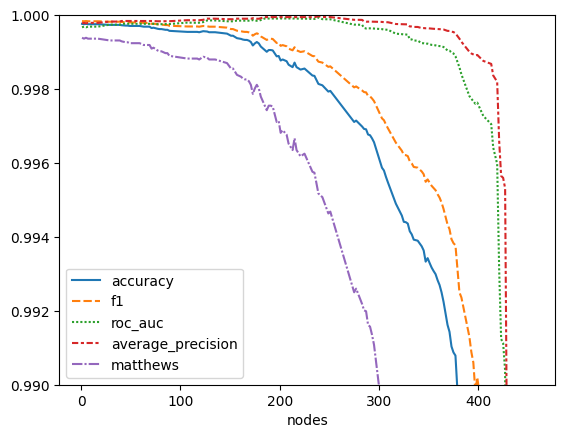

In [29]:
opt1 = OptimisedDecisionTree("building1")
opt1.fit(x_train1, y_train1, x_val1, y_val1)

df = opt1.results
df = pd.DataFrame(df[["accuracy", "f1", "roc_auc", "average_precision", "matthews"]], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_ylim(0.99, 1.0)
display(plt)

opt1.model

0it [00:00, ?it/s]


<Axes: xlabel='nodes'>

DecisionTreeClassifier(ccp_alpha=3.0217255379809425e-06, random_state=42)

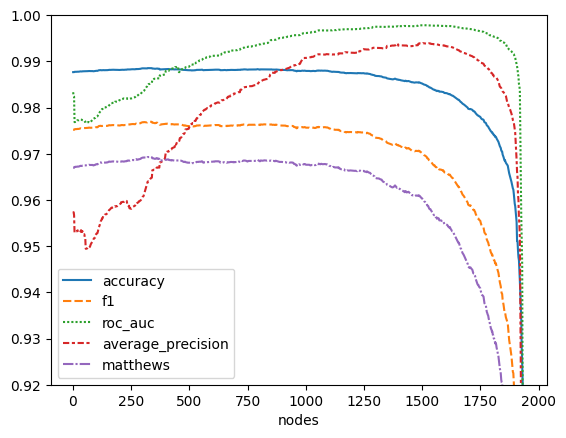

In [30]:
opt3 = OptimisedDecisionTree("building3")
opt3.fit(x_train3, y_train3, x_val3, y_val3)

df = opt3.results
df = pd.DataFrame(df[["accuracy", "f1", "roc_auc", "average_precision", "matthews"]], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_ylim(0.92, 1.0)
display(plt)

opt3.model